# Setting-Get Data

In [1]:
import neptune.new as neptune
import numpy as np
API_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4Njg5NjEzOC1mYWVjLTQ4NGUtOWY0NS1kZDIwM2M3NjVhN2IifQ=='

In [2]:
project = neptune.get_project(name='joao.d.oliveira/Computer-Vision', api_token=API_TOKEN)
runs_table_df = project.fetch_runs_table().to_pandas()
colsKeep = ['sys/id', 'parameters/run_name', 'parameters/learning_rate', 'parameters/loss_function', 
            'parameters/optimizer', 'parameters/momentum', 'metrics/test/MAE', 'metrics/test/MAE-Smooth',
            'metrics/test/MSE', 'metrics/train/loss', 'parameters/n_epochs', 'parameters/batch_size',
            'duration', 'sys/creation_time']

runs_table_df = runs_table_df[colsKeep]
ids = runs_table_df['sys/id'].values
runs_table_df = runs_table_df.set_index('sys/id')

In [3]:
runs_table_df = runs_table_df.rename(columns={'parameters/run_name': 'run_name',
                                              'parameters/learning_rate':'LR',
                                              'parameters/loss_function':'loss_function',
                                              'parameters/optimizer':'optimizer',
                                              'parameters/momentum': 'momentum',
                                              'metrics/test/MAE': 'result_MAE',
                                              'metrics/test/MAE-Smooth':'result_MAE-Smooth',
                                              'metrics/test/MSE': 'result_MSE',
                                              'metrics/train/loss':'train_loss',
                                              'parameters/n_epochs':'n_epochs',
                                              'parameters/batch_size':'batch',
                                              'sys/creation_time':'creation_time'})

runs_table_df = runs_table_df.replace({'loss_function': {0:'MAE', 1:'MAE-Smooth', 2:'MSE'}})
runs_table_df = runs_table_df.replace({'optimizer': {0:'Adam', 1:'SGD'}})
runs_table_df['model'] = list(runs_table_df.run_name.apply(lambda x:x[:6]))
#runs_table_df['name_rum'] = list(runs_table_df.run_name.apply(lambda x:x[:6]))

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#runs_table_df['name'] = le.fit_transform(list(runs_table_df.run_name.apply(lambda x:x[6:])))
#runs_table_df['name'] = list(runs_table_df.run_name.apply(lambda x:x[6:]))
runs_table_df['name'] = runs_table_df['run_name']

runs_table_df = runs_table_df.sort_values('name')

df_optm = [runs_table_df.loc[runs_table_df.optimizer == op] for op in runs_table_df.optimizer.unique()]
df_loss = [runs_table_df.loc[runs_table_df.loss_function == lo] for lo in runs_table_df.loss_function.unique()]
df_LR = [runs_table_df.loc[runs_table_df.LR == lr] for lr in runs_table_df.LR.unique()]
df_model = [runs_table_df.loc[runs_table_df.model == m] for m in runs_table_df.model.unique()]

dfs = [df_optm, df_loss, df_LR, df_model]
metrics = ['MSE', 'MAE-Smooth', 'MAE']
divisions = ['Optimizers', 'Loss-Functions', 'LearningRates', 'Model']
name_processing = ['Opti', 'Loss', 'LR', 'v1.']
name_division = [runs_table_df.optimizer.unique(),
                 runs_table_df.loss_function.unique(),
                 runs_table_df.LR.unique(),
                 runs_table_df.model.unique()]

for d, df in enumerate(dfs):
    for f in range(len(df)):
        pnames = df[f].name.apply(lambda x:"-".join([a for a in x.split('-') if (name_processing[d] not in a) and ('Mom' not in a)]))
        #pnames = le.fit_transform(pnames)
        df[f].name = pnames

/opt/homebrew/Caskroom/miniforge/base/envs/cv-nd/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [5]:
import pandas as pd
dfSummaryMeans = pd.DataFrame(index=['MAE', 'MAE-Smooth', 'MSE'], columns=[i for c in name_division for i in c])
dfSummaryMSE = pd.DataFrame(index=range(len(ids)))
dfSummaryMAE_Smooth = pd.DataFrame(index=range(len(ids)))
dfSummaryMAE = pd.DataFrame(index=range(len(ids)))

for i, division in enumerate(divisions):
    for d in range(len(dfs[i])):
        metric = 'MSE'
        df_n = pd.DataFrame(dfs[i][d][f'result_{metric}'].values , columns=[name_division[i][d]])
        dfSummaryMSE=pd.merge(dfSummaryMSE, df_n, how='outer', left_index=True, right_index=True)

        metric = 'MAE-Smooth'
        df_n = pd.DataFrame(dfs[i][d][f'result_{metric}'].values , columns=[name_division[i][d]])
        dfSummaryMAE_Smooth=pd.merge(dfSummaryMAE_Smooth, df_n, how='outer', left_index=True, right_index=True)

        metric = 'MAE'
        df_n = pd.DataFrame(dfs[i][d][f'result_{metric}'].values , columns=[name_division[i][d]])
        dfSummaryMAE=pd.merge(dfSummaryMAE, df_n, how='outer', left_index=True, right_index=True)        
        for m in range(len(metrics)): 
            v = round(np.mean(dfs[i][d][f'result_{metrics[m]}']), 5)
            dfSummaryMeans.loc[metrics[m], name_division[i][d]] = v

dfSummaryMSE = dfSummaryMSE.dropna(how="all")
dfSummaryMAE_Smooth = dfSummaryMAE_Smooth.dropna(how="all")
dfSummaryMAE = dfSummaryMAE.dropna(how="all")

## Get full training-loss

In [6]:
for i in ids[1:]:
    run = neptune.init(project='joao.d.oliveira/Computer-Vision', run=i, mode="read-only", api_token=API_TOKEN)
    runs_table_df.loc[i, 'metrics/train/loss'] = ";".join(map(str, list(run['metrics/train/loss'].fetch_values().value)))

https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-486
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-485
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-484
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-483
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-482
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-481
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-480
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-479
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-478
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-477
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-476
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-475
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-474
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-473
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-472
https://app.neptune.ai/jo

https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-304
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-303
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-302
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-301
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-300
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-299
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-298
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-297
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-296
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-295
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-294
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-293
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-292
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-291
https://app.neptune.ai/joao.d.oliveira/Computer-Vision/e/COM-290
https://app.neptune.ai/jo

# Analysis

## Plot Analysis

### All Combinations

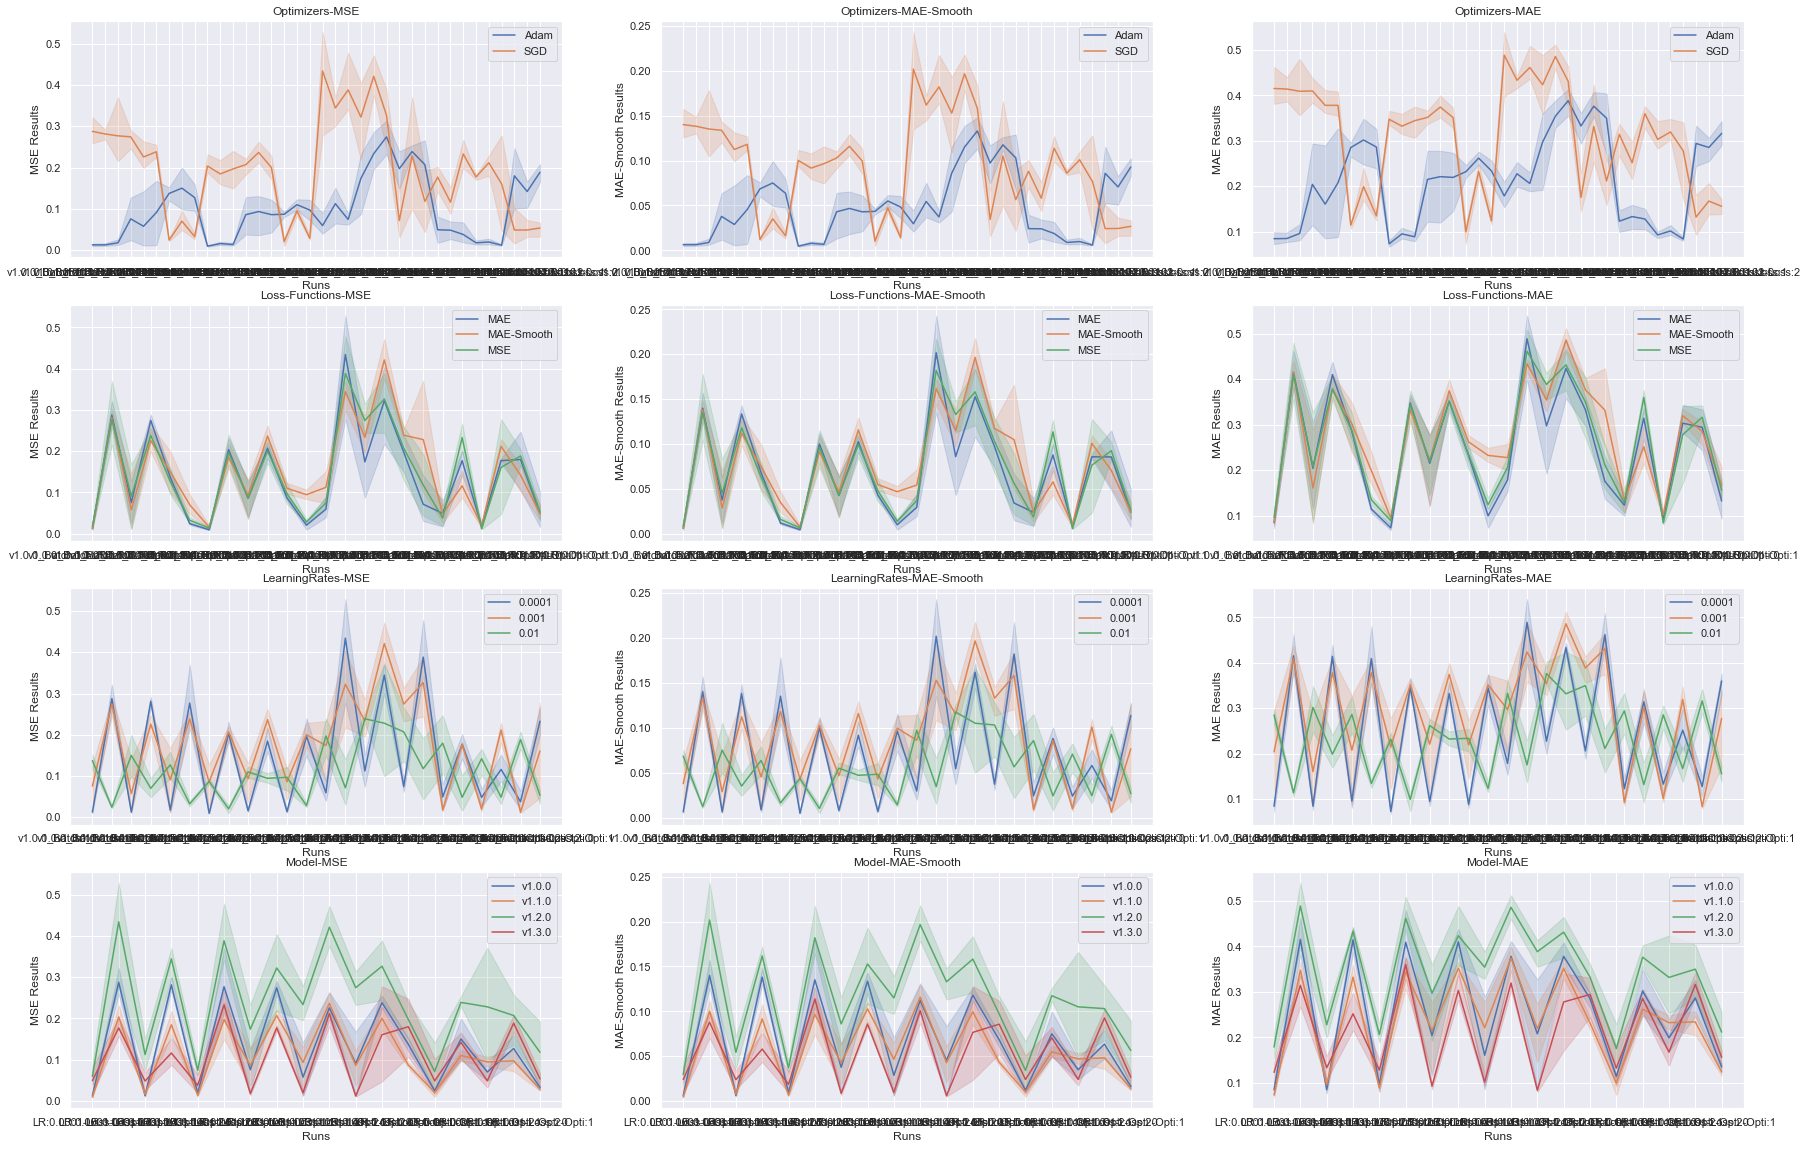

In [6]:
#%matplotlib notebook
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

sns.set(rc={"figure.figsize":(30, 20)})
fig, sub = plt.subplots(4, 3)
# Plot the responses for different events and regions
for d, df in enumerate(dfs):
    for i in range(len(metrics)):
        for f in range(len(df)):
            g = sns.lineplot(x="name",
                             y=df[f][f'result_{metrics[i]}'], data=df[f],
                             ax=sub[d, i])
            g.legend(labels=name_division[d])
            g.set_xlabel("Runs")
            g.set_ylabel(f"{metrics[i]} Results")
            g.set_title(f"{divisions[d]}-{metrics[i]}")
plt.savefig('aux/allcombinations.png', dpi=300)
plt.show(g)

### Plot only one Measure / Metric

<IPython.core.display.Javascript object>


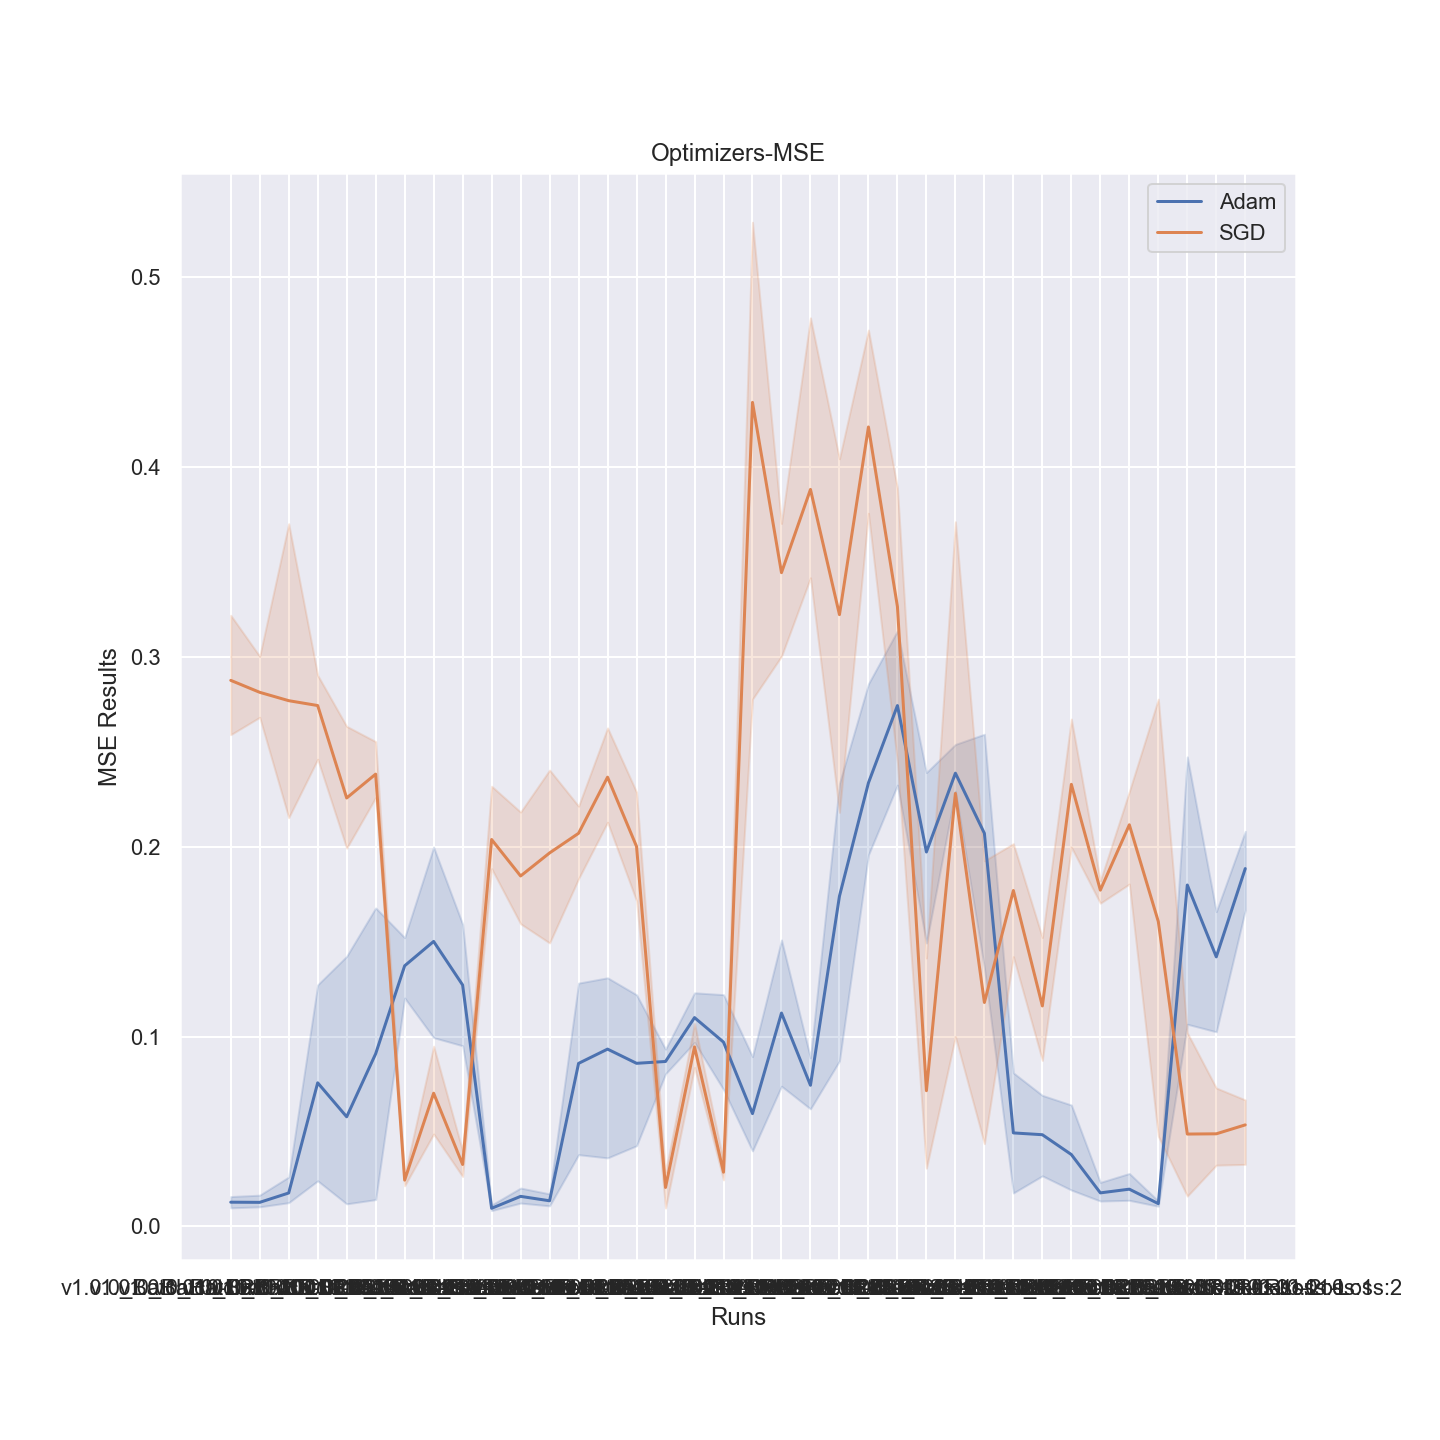

In [7]:
%matplotlib notebook
import seaborn as sns

measure, metric = 0, 0
sns.set(rc={"figure.figsize":(10, 10)})

# Plot the responses for different events and regions
for f in range(len(dfs[measure])):
    g = sns.lineplot(x="name",
                     y=dfs[measure][f][f'result_{metrics[metric]}'],
                     data=dfs[measure][f])
    g.legend(labels=name_division[measure])
    g.set_xlabel("Runs")
    g.set_ylabel(f"{metrics[metric]} Results")
    g.set_title(f"{divisions[measure]}-{metrics[metric]}")
    
fig = g.get_figure()


### Plot Summary

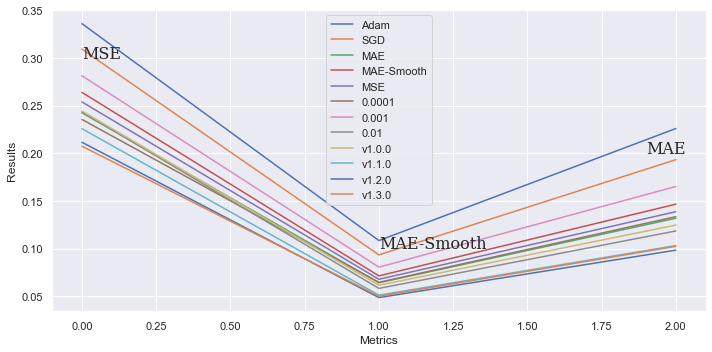

In [8]:
%matplotlib inline

fig = plt.figure(figsize=(10,5))
for c in dfSummaryMeans.columns:
    x, y = list(range(len(dfSummaryMeans.index))), dfSummaryMeans[c].values
    plt.plot(x, y, label=c)

plt.legend(loc='upper center')
font_defined = {'family': 'serif', 'weight': 'normal', 'size': 16}
plt.xlabel("Metrics")
plt.ylabel("Results")
plt.text(0.0, 0.3, "MSE", font=font_defined)
plt.text(1, 0.10, 'MAE-Smooth', font=font_defined)
plt.text(1.9, 0.2, 'MAE', font=font_defined)
plt.tight_layout()
plt.savefig('aux/all_divisions.png', dpi=300)
plt.show();

### Plot OneMeasure-AllParameters

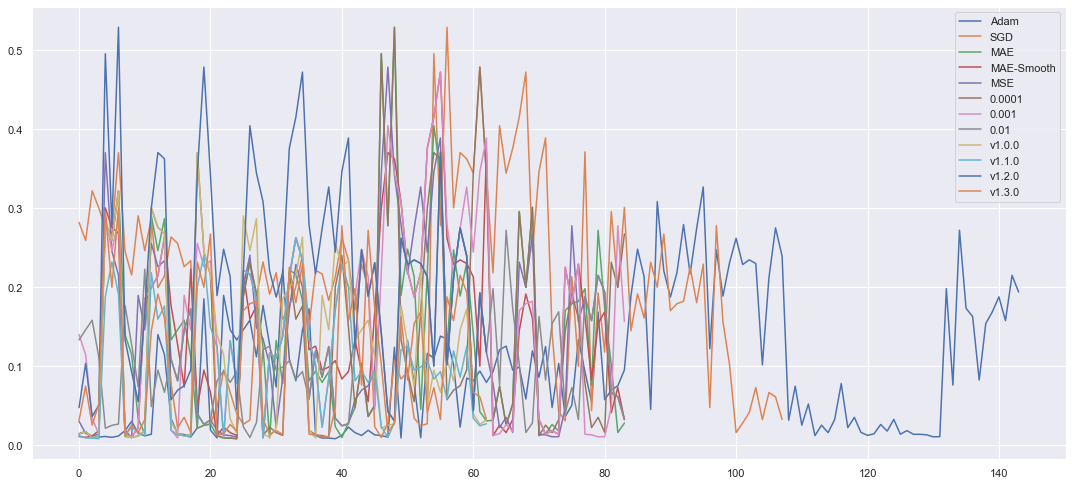

In [9]:
%matplotlib inline

fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(3,1,1)
m = 'MSE'
for c in dfSummaryMSE.columns:
    x, y = list(range(len(dfSummaryMSE.index))), dfSummaryMSE[c].values
    plt.plot(x, y, label=c)

plt.legend(loc='upper right')
plt.tight_layout()
plt.show();

## TextAnalysis

In [9]:
for i, division in enumerate(divisions):
    print(f"Statistics from {division:<13} runs:")
    for d in range(len(dfs[i])):
        print(f"\t{name_division[i][d]:<10}", end=' -- ')
        for m in range(len(metrics)): 
            v = dfSummaryMeans.loc[metrics[m], name_division[i][d]]
            print(f"{metrics[m]:<7}: {v:<8}", end='; ')

        print(f"{round(np.mean(dfs[i][d]['duration']), 2)} seg")

Statistics from Optimizers    runs:
	Adam       -- MSE    : 0.09847 ; MAE-Smooth: 0.04868 ; MAE    : 0.21172 ; 389.43 seg
	SGD        -- MSE    : 0.19343 ; MAE-Smooth: 0.09349 ; MAE    : 0.30938 ; 336.65 seg
Statistics from Loss-Functions runs:
	MAE        -- MSE    : 0.13195 ; MAE-Smooth: 0.06427 ; MAE    : 0.24262 ; 368.23 seg
	MAE-Smooth -- MSE    : 0.14672 ; MAE-Smooth: 0.07147 ; MAE    : 0.26404 ; 366.34 seg
	MSE        -- MSE    : 0.13883 ; MAE-Smooth: 0.06791 ; MAE    : 0.25405 ; 365.87 seg
Statistics from LearningRates runs:
	0.0001     -- MSE    : 0.1336  ; MAE-Smooth: 0.0647  ; MAE    : 0.23565 ; 369.89 seg
	0.001      -- MSE    : 0.1653  ; MAE-Smooth: 0.0806  ; MAE    : 0.28147 ; 364.94 seg
	0.01       -- MSE    : 0.11861 ; MAE-Smooth: 0.05834 ; MAE    : 0.24359 ; 365.6 seg
Statistics from Model         runs:
	v1.0.0     -- MSE    : 0.12476 ; MAE-Smooth: 0.06164 ; MAE    : 0.24453 ; 353.61 seg
	v1.1.0     -- MSE    : 0.1033  ; MAE-Smooth: 0.05123 ; MAE    : 0.22597 ; 517.18 

In [10]:
i = 0
for d in range(len(dfs[i])):
    print(f"{name_division[i][d]:<10}")
    for m in dfs[i][d].momentum.unique():
        print(f'{m:<15} - ', end='')
        for metric in metrics:
            v = round(np.mean(dfs[i][d].loc[dfs[i][d].momentum == m, f'result_{metric}']), 5)
            print(f"{metric:<7}: {v:<8}", end='; ')
        print()

Adam      
(0.8, 0.9)      - MSE    : 0.09555 ; MAE-Smooth: 0.04726 ; MAE    : 0.20994 ; 
(0.85, 0.95)    - MSE    : 0.08981 ; MAE-Smooth: 0.04458 ; MAE    : 0.20286 ; 
(0.85, 0.999)   - MSE    : 0.10119 ; MAE-Smooth: 0.05007 ; MAE    : 0.21406 ; 
(0.9, 0.999)    - MSE    : 0.10733 ; MAE-Smooth: 0.0528  ; MAE    : 0.22002 ; 
SGD       
0.85            - MSE    : 0.18844 ; MAE-Smooth: 0.09183 ; MAE    : 0.30909 ; 
0.8             - MSE    : 0.19264 ; MAE-Smooth: 0.09322 ; MAE    : 0.30816 ; 
0.9             - MSE    : 0.19921 ; MAE-Smooth: 0.09541 ; MAE    : 0.31088 ; 
